# Random Forests vs. Decision Tree

We are building a random forest on our own and compare it to a decision tree.

First some imports:

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from openml.datasets import get_dataset
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# a random number generator with fixed random state
random_state = 0
rng = np.random.default_rng(random_state)

Next we define our utility functions
- data frame shuffling
- computing the majority vote for each row in the provided data

In [2]:
def shuffle_df(df: pd.DataFrame):
    return df.sample(frac=1).reset_index(drop=True)


def get_majority_vote(predictions: np.ndarray):
    labels = []
    for pred in predictions:
        values, counts = np.unique(pred, return_counts=True)  # we want to count along the rows
        max_index = np.argmax(counts)
        label = values[max_index]
        labels.append(label)
    return np.array(labels)

## Building the Random Forest

### Parameters:
- the number of trees 
- the fraction of data points used to train each tree

We set the number of dimensions for each tree to sqrt(d)

In [3]:
class RandomForest:
    def __init__(self, n_components: int,
                 frac_observations_per_tree: float = 0.2):
        self.n_components = n_components
        self.frac_observations_per_tree = frac_observations_per_tree
        self.forest = [DecisionTreeClassifier() for _ in range(n_components)]
        self.features_per_tree = []

    # for now we only support dataframes, but we could extend our forest to also handle numpy arrays
    def fit(self, X: pd.DataFrame, y: pd.Series):
        n_dimensions = X.shape[-1]
        num_features_per_tree = np.sqrt(n_dimensions).astype(int)  # compute the number of features used in each tree
        self.features_per_tree = []  # we need to store those features for the prediction phase later on
        all_data_indices = np.arange(len(y))
        num_observations_per_tree = int(len(all_data_indices * self.frac_observations_per_tree))
        for tree in self.forest:  # loop over all trees in the forest
            # subsample data and dimensions
            sampled_indices = rng.choice(all_data_indices, size=num_observations_per_tree, replace=True)  # bootstrap
            sampled_dimensions = rng.choice(X.columns, num_features_per_tree, replace=False)  # choose dimensions randomly
            self.features_per_tree.append(sampled_dimensions)  # store those dimensions

            # train tree
            X_tree = X.loc[sampled_indices, sampled_dimensions]  # select samples and dimensions
            y_tree = y.loc[sampled_indices]
            tree.fit(X_tree, y_tree)  # fit the tree

    def predict(self, X: pd.DataFrame):
        predictions = [
            tree.predict(X[dimensions])  # get the dimensions that belong to each tree
            for dimensions, tree in zip(self.features_per_tree, self.forest)
        ]
        predictions = np.array(predictions).T  # this has shape (#data, #components)
        labels = get_majority_vote(predictions)
        return labels

## Evaluation

### Dataset

We classify measurements from 16 chemical sensors exposed to 6 gases at various levels of concentrations.

There are six possible classes:

1. Ethanol 
2. Ethylene  
3. Ammonia 
4. Acetaldehyde 
5. Acetone 
6. Toluene

- Our goal is to classify the type of gas from the measurements

### Data loading and preprocessing

In [4]:
GAS_IDENTIFICATION = 1476
data = get_dataset(GAS_IDENTIFICATION).get_data()[0]
data.dropna(axis=0, inplace=True)
if "id" in data.columns:
    data = data.drop("id", axis=1)
data = shuffle_df(data)
data.rename({"Class": "class"}, axis=1, inplace=True)
data["class"] = LabelEncoder().fit_transform(data["class"])

num_train = int(0.7 * len(data))
train, test = data.loc[:num_train], data.loc[num_train:]

We compare four algorithms:

In [5]:
algorithms = {
    "Decision tree": DecisionTreeClassifier(),
    "Random forest ( 3)": RandomForest(n_components=3),
    "Random forest (10)": RandomForest(n_components=10),
    "Random forest (30)": RandomForest(n_components=30),
    "Random forest (100)": RandomForest(n_components=100),
}

Fit each algorithm on the same data:

In [6]:
X_train = train.drop("class", axis=1)
y_train = train["class"]
for alg in algorithms.values():
    alg.fit(X_train, y_train)

- Evaluate the algorithms on train and test data
- Store the results in a dataframe

In [7]:
eval_datasets = {"Training data": train, "Test data": test}
result_df = []
for ds_name, eval_data in eval_datasets.items():
    for alg_name, alg in algorithms.items():
        majority_vote_agreement = np.sum(test["class"])
        if majority_vote_agreement < 0.5 * len(eval_data):
            majority_vote_agreement = len(eval_data) - majority_vote_agreement
        X_this = eval_data.drop("class", axis=1)
        y_this = eval_data["class"]
        predictions = alg.predict(X_this)
        correct_predictions = predictions == y_this
        num_correct = np.sum(correct_predictions)
        accuracy = num_correct / len(eval_data)
        result_df.append([ds_name, alg_name, accuracy])

result_df = pd.DataFrame(result_df, columns=["Dataset", "Algorithm", "Accuracy"])

Let's have a look at the result:

,Dataset,Algorithm,Accuracy
0,Training data,Decision tree,1.000000
1,Training data,Random forest ( 3),0.995995
2,Training data,Random forest (10),0.999897
3,Training data,Random forest (30),1.000000
4,Training data,Random forest (100),1.000000
5,Test data,Decision tree,0.968368
6,Test data,Random forest ( 3),0.975557
7,Test data,Random forest (10),0.990415
8,Test data,Random forest (30),0.994009
9,Test data,Random forest (100),0.994249


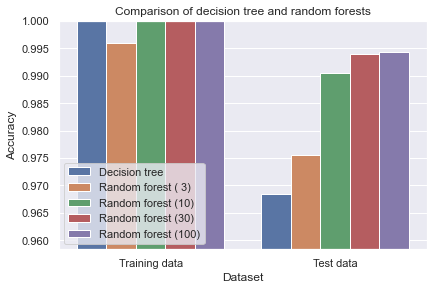

In [8]:
display(result_df)
sns.barplot(data=result_df, x="Dataset", y="Accuracy", hue="Algorithm")
plt.ylim((np.min(result_df["Accuracy"]) - 0.01, 1.0))
plt.title("Comparison of decision tree and random forests")
plt.legend(loc="lower left")
plt.tight_layout(pad=.5)
plt.show()

- Decision tree has perfect performance on training data but lowest performance on test data
    - slight overfitting
- Random forest with only 3 components already outperforms decision tree on test data (with our configuration)
- Performance of random forest increases with number of components but saturates eventually